In [1]:
import json
import numpy as np
import pandas as pd
import csv
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score
from keras.models import model_from_json

sns.set_style("darkgrid")

In [2]:
data = pd.read_pickle("synergy_carry_value_df_encoded.pkl")
data_train, data_test = train_test_split(data,shuffle=True,random_state=6453,test_size=.2)

In [3]:
model = Sequential()
model.add(Dense(70, input_dim=len(list(data.columns)[:-5]), activation="relu"))
model.add(Dense(25, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.fit(np.asarray(data_train[list(data.columns)[:-5]].values).astype('float32'), np.asarray(data_train["Top 4"]).astype('int'), validation_split = .2, epochs=100, batch_size=10000)

Epoch 1/100
10/10 [==============================] - 1s 65ms/step - loss: 0.7587 - accuracy: 0.5262 - val_loss: 0.6802 - val_accuracy: 0.5311
Epoch 2/100
10/10 [==============================] - 0s 18ms/step - loss: 0.6424 - accuracy: 0.6243 - val_loss: 0.6306 - val_accuracy: 0.6018
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 0.6013 - accuracy: 0.6798 - val_loss: 0.5779 - val_accuracy: 0.7045
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.71 - 0s 24ms/step - loss: 0.5638 - accuracy: 0.7202 - val_loss: 0.5493 - val_accuracy: 0.7273
Epoch 5/100
10/10 [==============================] - 0s 22ms/step - loss: 0.5349 - accuracy: 0.7393 - val_loss: 0.5209 - val_accuracy: 0.7472
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 0.5105 - accuracy: 0.7525 - val_loss: 0.5020 - val_accuracy: 0.7577
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 0.4935 - accuracy: 0.7630 - val_

10/10 [==============================] - 0s 18ms/step - loss: 0.4062 - accuracy: 0.8099 - val_loss: 0.4172 - val_accuracy: 0.8054
Epoch 59/100
10/10 [==============================] - 0s 18ms/step - loss: 0.4041 - accuracy: 0.8115 - val_loss: 0.4163 - val_accuracy: 0.8073
Epoch 60/100
10/10 [==============================] - 0s 17ms/step - loss: 0.4041 - accuracy: 0.8115 - val_loss: 0.4161 - val_accuracy: 0.8070
Epoch 61/100
10/10 [==============================] - 0s 15ms/step - loss: 0.4040 - accuracy: 0.8116 - val_loss: 0.4165 - val_accuracy: 0.8072
Epoch 62/100
10/10 [==============================] - 0s 18ms/step - loss: 0.4036 - accuracy: 0.8116 - val_loss: 0.4166 - val_accuracy: 0.8072
Epoch 63/100
10/10 [==============================] - 0s 20ms/step - loss: 0.4039 - accuracy: 0.8114 - val_loss: 0.4167 - val_accuracy: 0.8064
Epoch 64/100
10/10 [==============================] - 0s 23ms/step - loss: 0.4031 - accuracy: 0.8119 - val_loss: 0.4164 - val_accuracy: 0.8068
Epoch 65/100

In [4]:
prob = model.predict(np.asarray(data_train[list(data.columns)[:-5]].values).astype('float32'))
print(roc_auc_score(np.asarray(data_train["Top 4"].values).astype('int'),prob[:,1]))

pred = [np.argmax(x) for x in prob]
print(accuracy_score(pred, np.asarray(data_train["Top 4"].values).astype('int')))

0.8990318822232881
0.8135272714993627


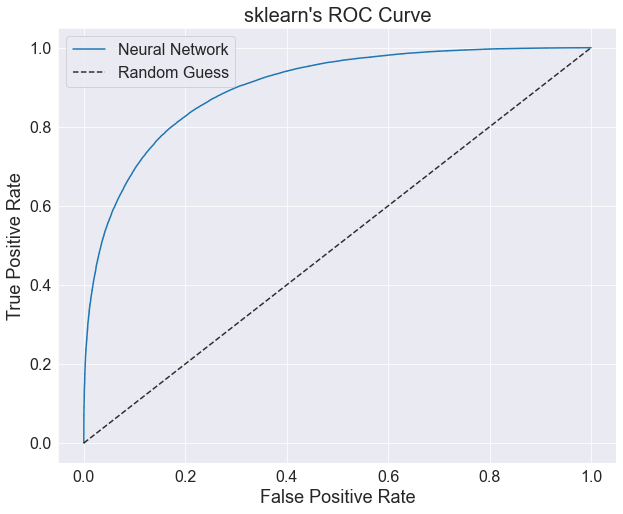

In [5]:
fprs, tprs, thresholds = roc_curve(np.asarray(data_train["Top 4"].values).astype('int'),prob[:,1])

plt.figure(figsize=(10,8))

plt.plot(fprs, tprs, label="Neural Network")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), 'k--', alpha=.8, label="Random Guess")

plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.legend(fontsize=16)

plt.title("sklearn's ROC Curve", fontsize=20)

plt.show()

In [6]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### We will choose this model and will work now witht test set

In [7]:
prob = model.predict(np.asarray(data_test[list(data.columns)[:-5]].values).astype('float32'))
print(roc_auc_score(np.asarray(data_test["Top 4"].values).astype('int'),prob[:,1]))

pred = [np.argmax(x) for x in prob]
print(accuracy_score(pred, np.asarray(data_test["Top 4"].values).astype('int')))

0.8911035929618447
0.8093533682255614


The model performs slight worst on the test set as expected since we can assume that we may have overfitted a bit on the training set but this is still within margin of error since we only require an accuracy of 80%. We can focus more on traits in such analysis. Below we assume Gold synergies.

In [8]:
features = list(data_test.columns)[:22]
for i in range(len(features)):
    temp = data_test[data_test[features[i]] == 3]
    prob = model.predict(np.asarray(temp[list(temp.columns)[:-5]].values).astype('float32'))
    pred = [np.argmax(x) for x in prob]
    try:
        print("For Synergy " + features[i] + " the ROC AUC of model is:" + 
              str(roc_auc_score(np.asarray(temp["Top 4"].values).astype('int'),prob[:,1])))
        print("For Synergy " + features[i] + " the accuracy of model is:" + 
              str(accuracy_score(np.asarray(temp["Top 4"].values).astype('int'),pred)))
        print()
    except:
        print("ROC AUC of " + features[i] + " is not defined.")
        print("For Synergy " + features[i] + " the accuracy of model is:" + 
              str(accuracy_score(np.asarray(temp["Top 4"].values).astype('int'),pred)))
        print()

For Synergy Set5_Assassin the ROC AUC of model is:0.8872059690568647
For Synergy Set5_Assassin the accuracy of model is:0.8388969521044993

For Synergy Set5_Brawler the ROC AUC of model is:0.8772486772486774
For Synergy Set5_Brawler the accuracy of model is:0.7900943396226415

For Synergy Set5_Cavalier the ROC AUC of model is:0.879434619035899
For Synergy Set5_Cavalier the accuracy of model is:0.8296089385474861

For Synergy Set5_Forgotten the ROC AUC of model is:0.8686435715456866
For Synergy Set5_Forgotten the accuracy of model is:0.8259911894273128

For Synergy Set5_Ironclad the ROC AUC of model is:0.8819230161390497
For Synergy Set5_Ironclad the accuracy of model is:0.8040870724122612

For Synergy Set5_Legionnaire the ROC AUC of model is:0.8468013468013469
For Synergy Set5_Legionnaire the accuracy of model is:0.7787610619469026

ROC AUC of Set5_Nightbringer is not defined.
For Synergy Set5_Nightbringer the accuracy of model is:1.0

For Synergy Set5_Redeemed the ROC AUC of model is:

### We're going to focus on conditional probability of this model
What we will do is predicting the probability of a win given that the model predicts and win. Preferably we want this percentage to be greater than 80% or we want to find the conditions to ensure that it will be above 80%. This way assuming we are using the winning team compositions from the model then in the long run we should expect not the drop in rank.

This is due to the the following: If we play 5 top 4 team composition (according to the model which is >= 80% correct) then on average 1 of the 5 will place in bottom 4. The worst case would be having 4 place fourth and 1 place eighth which in terms of point rankings a fourth place is +10 and an eighth is -40 and so this will equal out. 

##### Underlining assumptions for strategy
Some reasonable narutal assumption for initial run would be to assume the tier of carries will be 2 or 3 since tier 1 carries are somewhat weak relative to tier 2 carries. Further analysis can be made for comparison between tier 2 champions vs the Tier 1 transition champions


In [9]:
from sklearn.metrics import confusion_matrix
traits_col = list(data.columns)[:22]

In [10]:
print("Below is the probability of a win assuming that the model predicts a win by gold/chromatic synergies")
print()
for x in traits_col:
    test = data_test[(data_test["Primary_Carry_Tier"] >= 2) & (data_test["Secondary_Carry_Tier"] >= 2) & 
                      (data_test["Third_Carry_Tier"] >= 2) & (data_test[x] >= 3)]
    predict = model.predict(np.asarray(test[list(data.columns)[:-5]].values).astype('float32'))
    predict_placement = []
    for i in range(len(predict)):
        predict_placement.append(np.argmax(predict[i]))
    try:
        tn, fp, fn, tp = confusion_matrix(np.asarray(test["Top 4"].values).astype('int'),predict_placement).ravel()
        print(x)
        print("True Positive = " + str(tp) + " False Positive = " + str(fp))
        print("True Negative = " + str(tn) + " False Negative = " + str(fn))
        print("Probability of win assuming win predicted = " + str(tp/(tp + fp)))
        print("Probability of loss assuming loss predicted = " + str(tn/(tn + fn)))
        print()
    except:
        print(x + " has an error not enough info. Accuracy is " + str(np.sum(predict_placement == np.asarray(test["Top 4"].values).astype('int'))/len(predict_placement)))
        print()

Below is the probability of a win assuming that the model predicts a win by gold/chromatic synergies

Set5_Assassin
True Positive = 336 False Positive = 33
True Negative = 50 False Negative = 27
Probability of win assuming win predicted = 0.9105691056910569
Probability of loss assuming loss predicted = 0.6493506493506493

Set5_Brawler
True Positive = 136 False Positive = 41
True Negative = 101 False Negative = 27
Probability of win assuming win predicted = 0.768361581920904
Probability of loss assuming loss predicted = 0.7890625

Set5_Cavalier
True Positive = 184 False Positive = 19
True Negative = 50 False Negative = 24
Probability of win assuming win predicted = 0.9064039408866995
Probability of loss assuming loss predicted = 0.6756756756756757

Set5_Forgotten
True Positive = 251 False Positive = 30
True Negative = 45 False Negative = 21
Probability of win assuming win predicted = 0.8932384341637011
Probability of loss assuming loss predicted = 0.6818181818181818

Set5_Ironclad
True 